<a href="https://colab.research.google.com/github/innovateDotAI/ReadyToUseModels/blob/main/GNN_GraphClassification_Dataset%3DTUDataset(PROTEINS)_Algo%3DGCN__v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

v1 : This notebook details the steps related to Graph classification using Graph Convolution Network(GCN) algorithm. 

#Library used

In [ ]:
!pip install --upgrade scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install spektral

In [ ]:
import spektral
import keras
import matplotlib.pyplot as plt
import numpy as np
from random import sample 

# Dataset

**About dataset**

The Benchmark "PROTEINS" Data Sets for Graph Kernels from [TU Dortmund](https://chrsmrrs.github.io/datasets/docs/datasets/).

**Load The dataset**

In [ ]:
dataset = spektral.datasets.tudataset.TUDataset("PROTEINS", clean=True) #clean: if True, rload a version of the dataset with no isomorphic graphs.

Successfully loaded PROTEINS.


**Problem statement**

PROTEINS dataset has 975 diffrent protein graph with binary lables. Our task is to classify the graphs

**Training and Test Dataset creation**

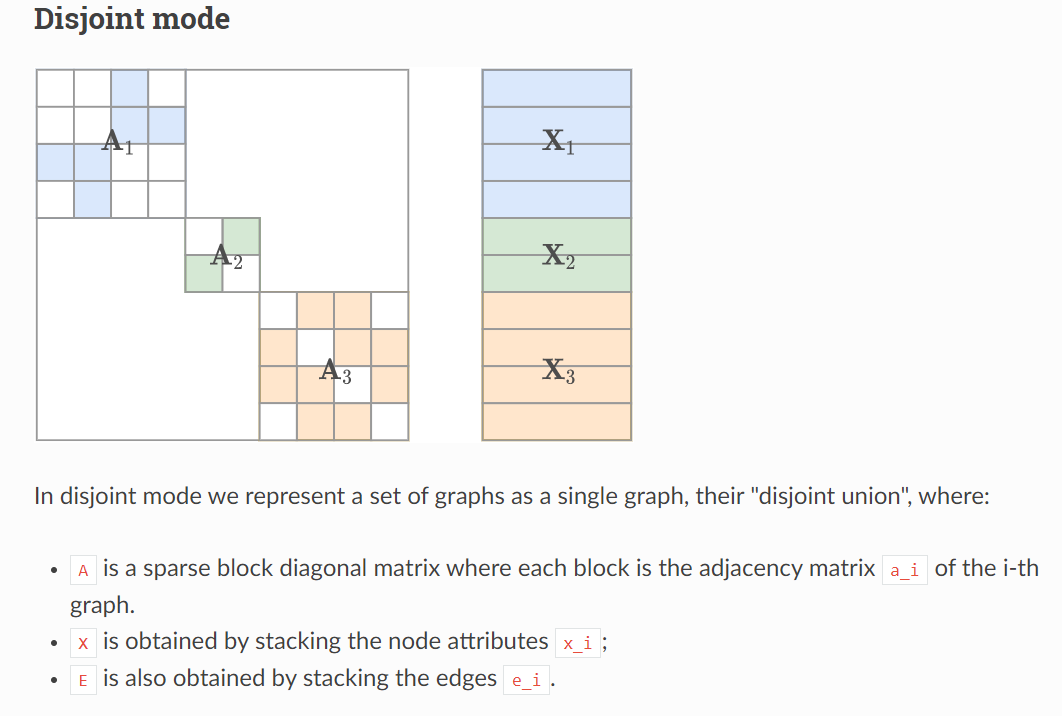

In [ ]:
# Train / test split
idxs = np.random.permutation(len(dataset))  # Random split
split = int(0.9 * len(dataset)) # Taking 90% graphs for training
idx_tr, idx_te = np.split(idxs, [split])
# Get train and test datsets
dataset_tr, dataset_te = dataset[idx_tr], dataset[idx_te]
# Get loaders using DisjointLoader
'''
dataset: a graph Dataset;
node_level: bool, if True stack the labels vertically for node-level prediction;
batch_size: size of the mini-batches;
epochs: number of epochs to iterate over the dataset. By default (None) iterates indefinitely;
shuffle: whether to shuffle the data at the start of each epoch.

For each batch, returns a tuple (inputs, labels).

inputs is a tuple containing:

x: node attributes of shape [n_nodes, n_node_features];
a: adjacency matrices of shape [n_nodes, n_nodes];
e: edge attributes of shape [n_edges, n_edge_features];
i: batch index of shape [n_nodes].
labels have shape [batch, n_labels] if node_level=False or [n_nodes, n_labels] otherwise.
'''
loader_tr = spektral.data.loaders.DisjointLoader(dataset_tr, node_level=False, batch_size=3, epochs=1, shuffle=True)
loader_te = spektral.data.loaders.DisjointLoader(dataset_te, node_level=False, batch_size=1, epochs=1, shuffle=True)

In [ ]:
loader_tr.steps_per_epoch

293

# Algorithm design and execution

**GCN Algorith details**

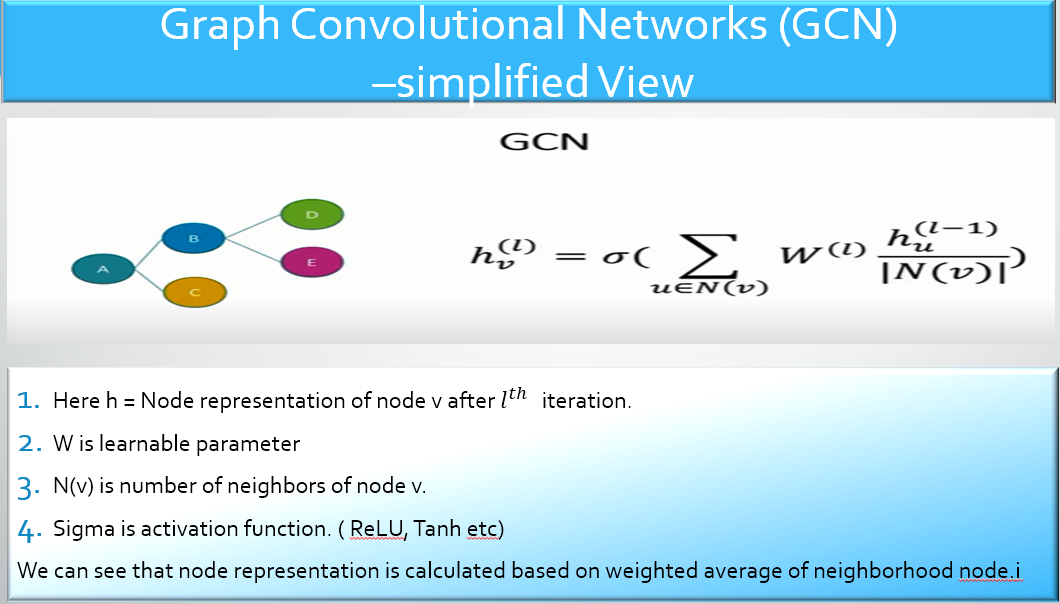
**Global Avg, Pooling details**

An average pooling layer. Pools a graph by computing the average of its node features.

**Build and execute Model**

We are create model by Keras API subclassing method where we create GCN class by inheriting keras.models.Model.

super() lets you avoid referring to the base class explicitly

Based on number of layers self.convs list will be populated with GCNConv layers.
Pooling DNN and Dropout added for classification.

The Input to all of these layers has been supplied by Call method.

In [ ]:
class GCN(keras.models.Model):
    
    def __init__(self, channels, n_layers, dropout_rate=.2):
        
        super().__init__()
        
        self.conv1 = spektral.layers.GCNConv(channels)
        self.convs = []
        
        for _ in range(1, n_layers):
            self.convs.append(
                spektral.layers.GCNConv(channels)
            )
        self.pool = spektral.layers.GlobalAvgPool()
        self.dense1 = keras.layers.Dense(channels, activation='relu')
        self.dropout = keras.layers.Dropout(dropout_rate)
        self.dense2 = keras.layers.Dense(dataset.n_labels, activation='softmax')

    def call(self, inputs):
        x, a, i = inputs
        x = self.conv1([x, a])
        for conv in self.convs:
            x = conv([x, a])
        x = self.pool([x, i])
        x = self.dense1(x)
        x = self.dropout(x)
        return self.dense2(x)

In [ ]:
# Instantiate the model
model = GCN(
    channels=16,
    dropout_rate=.1,
    n_layers=1
)

In [ ]:
# Set some params
LR = 5e-3 # 5e-3  # Learning rate
EPOCHS = 20  # Number of training epochs
PATIENCE = 30  # Patience for early stopping
# Define the optimizer
optimizer = keras.optimizers.RMSprop(LR)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(reduction='sum'),
    weighted_metrics=['acc'],
)

In [ ]:
history = model.fit(
    loader_tr.load(),
    steps_per_epoch=2,
    validation_data=loader_te.load(),
    validation_steps=2,
    epochs=EPOCHS
)

Epoch 1/20
1/2 [==============>...............] - ETA: 0s - loss: 8.1327 - acc: 0.6667

/usr/local/lib/python3.8/dist-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'TUDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


2/2 [==============================] - 1s 231ms/step - loss: 7.1826 - acc: 0.6667 - val_loss: 1.1057 - val_acc: 0.5000
Epoch 2/20
2/2 [==============================] - 0s 43ms/step - loss: 4.8041 - acc: 0.5000 - val_loss: 0.1354 - val_acc: 1.0000
Epoch 3/20
2/2 [==============================] - 0s 60ms/step - loss: 14.4159 - acc: 0.3333 - val_loss: 0.6183 - val_acc: 0.5000
Epoch 4/20
2/2 [==============================] - 0s 29ms/step - loss: 2.6183 - acc: 0.6667 - val_loss: 0.0134 - val_acc: 1.0000
Epoch 5/20
2/2 [==============================] - 0s 29ms/step - loss: 10.7521 - acc: 0.3333 - val_loss: 1.0706 - val_acc: 0.0000e+00
Epoch 6/20
2/2 [==============================] - 0s 41ms/step - loss: 4.5916 - acc: 0.3333 - val_loss: 1.8953 - val_acc: 0.0000e+00
Epoch 7/20
2/2 [==============================] - 0s 32ms/step - loss: 12.3986 - acc: 0.1667 - val_loss: 0.5030 - val_acc: 1.0000
Epoch 8/20
2/2 [==============================] - 0s 37ms/step - loss: 1.7950 - acc: 0.8333 - va

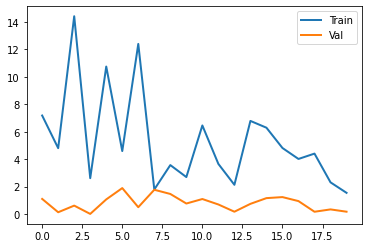

In [ ]:
# Plot the training efficiecncy
plt.plot(history.history['loss'], label='Train', lw=2)
plt.plot(history.history['val_loss'], label='Val', lw=2)
plt.legend()
plt.show()

In [ ]:
model.summary()

Model: "gcn_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gcn_conv_15 (GCNConv)       multiple                  80        
                                                                 
 global_avg_pool_7 (GlobalAv  multiple                 0         
 gPool)                                                          
                                                                 
 dense_14 (Dense)            multiple                  272       
                                                                 
 dropout_7 (Dropout)         multiple                  0         
                                                                 
 dense_15 (Dense)            multiple                  34        
                                                                 
Total params: 386
Trainable params: 386
Non-trainable params: 0
_______________________________________________________________

# Result Assesment and Interpretation

In [ ]:
# Evaluate model
print("Evaluating model.")
eval_results = model.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)
print("Done.\n" "Test loss: {}\n" "Test accuracy: {}".format(*eval_results))

Evaluating model.
56/98 [================>.............] - ETA: 0s - loss: 0.7375 - acc: 0.6964

98/98 [==============================] - 0s 2ms/step - loss: 0.7536 - acc: 0.6897
Done.
Test loss: 0.7535980343818665
Test accuracy: 0.6896551847457886


# Framework assesment and Future Work

1. As we can see the GCN accuary is lower then GAT accuracy becasue GCN is averaging the interation between nodes but GAT calculate the attention value based on importance of node.
2. These are two generaic message passing layers with following limitations:

    1.   Distance between two node is lost
    2.   Node with similar subtree will have same representation learning although there location is different. And this is not good in case we are doing link prediction for recomender kind of system.
    3. Information related to cycle is lost which is important for subgraph mining
    4. Node identtities are also lost


3. There are various framework suggested to overcome these limitation but one framework can not be generalized for all situation.

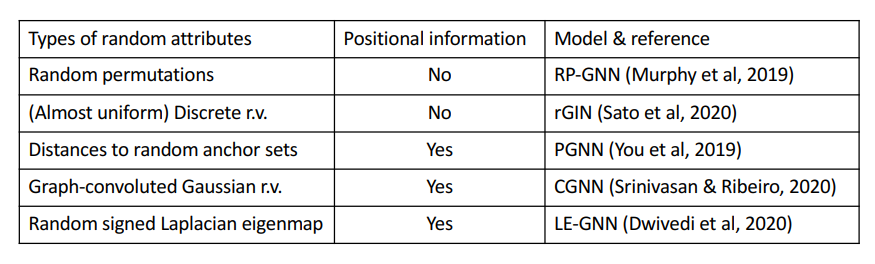

4. GCN and GAT is basaed on Message passing framework where node representation learning happens at 3 stage: Message passing, Aggregation and Updation. Aggregation and updation is invarient pooling.

5. In GNN we have inductive bias that each is affected by connecting node and for non-connecting node we can use message passing value through the connecting path.


# Scope of work in GNN

In general there are following task can be done suing GNN but not limited to:

      1. Node classification
      2. Link prediction
      3. Graph prediction
      4. Isomorphic graph mining
      5. Sub-graph mining

Application area wise if we can see then great about of research has been done in following areas:

GNN in Modern Recommender System

    1. GNN in Computer Vision
    2. GNN in NLP
    3. GNN in Program analysis
    4. GNN in software Mining
    5. GNN in Biomedicals Knowledge Graph Mining in Drug
    6. GNN in Predicting Protein Function and Interactions
    7. GNN in Anomaly Detection
    8. GNN in Urban Intelligence